In [1]:
# Importiamo tutte le librerie necessarie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc, recall_score, precision_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

from imblearn.over_sampling import SMOTE

from collections import Counter

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Caricamento del dataset
df_Neu_Net = pd.read_csv("data/df_EDA.csv")


### One-hot encoding delle variabili categoriche :
'person_home_ownership' e 'loan_intent' 

In [ ]:
df_Neu_Net = pd.get_dummies(df_Neu_Net, columns=['person_home_ownership', 'loan_intent'], prefix=['home', 'intent'], drop_first=True)
for column in df_Neu_Net:
    if df_Neu_Net[column].dtype == bool:
        df_Neu_Net[column] = df_Neu_Net[column].astype(int)

df_Neu_Net

,person_age,person_education,person_income,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,home_OWN,home_RENT,intent_EDUCATION,intent_HOMEIMPROVEMENT,intent_MEDICAL,intent_PERSONAL,intent_VENTURE
0,22,3,71948.0,35000.0,16.02,0.49,3,561,0,1,0,1,0,0,0,1,0
1,21,0,12282.0,1000.0,11.14,0.08,2,504,1,0,1,0,1,0,0,0,0
2,25,0,12438.0,5500.0,12.87,0.44,3,635,0,1,0,0,0,0,1,0,0
3,23,2,79753.0,35000.0,15.23,0.44,2,675,0,1,0,1,0,0,1,0,0
4,24,3,66135.0,35000.0,14.27,0.53,4,586,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38539,27,1,47971.0,15000.0,15.66,0.31,3,645,0,1,0,1,0,0,1,0,0
38540,37,1,65800.0,9000.0,14.07,0.14,11,621,0,1,0,1,0,1,0,0,0
38541,33,1,56942.0,2771.0,10.02,0.05,10,668,0,1,0,1,0,0,0,0,0
38542,29,2,33164.0,12000.0,13.23,0.36,6,604,0,1,0,1,1,0,0,0,0


### Separazione delle feature(X) e del target(y) : 

In [ ]:
X = df_Neu_Net.drop(columns=['loan_status'])  # tutte le colonne tranne la target
y = df_Neu_Net['loan_status']                 # solo la target

### Standardizzazione delle feature numeriche : 

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### LabelEncoder per target binario : 

In [ ]:
le = LabelEncoder() 
y = le.fit_transform(y.ravel())

C:\Users\torre\AppData\Local\Temp\ipykernel_13092\2575148504.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = le.fit_transform(y.ravel())


### Divisione in train e test set :

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
) # stratify=y per mantenere bilanciata la distribuzione della variabile target

### Verifichiamo conteggio e percentuale di ambedue le classi(y):

In [ ]:
print(df_Neu_Net['loan_status'].value_counts())
print(df_Neu_Net['loan_status'].value_counts(normalize=True) * 100)

loan_status
0    29143
1     9401
Name: count, dtype: int64
loan_status
0    75.609693
1    24.390307
Name: proportion, dtype: float64


### Calcolo di class weights(pesi di classe) :
        *solo se il dataset è sbilanciato

In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(0.6612979325727031), 1: np.float64(2.049926871426672)}


Questo risultato --> Class Weights: {0: 0.66, 1: 2.05} <-- ci mostra l'avvenuto bilanciamento delle classi, quindi :

    - La rete neurale darà maggiore peso ai casi rari (1);
    - La rete neurale darà meno peso ai casi comuni (0).

### Costruzione del modello : 

In [ ]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'), # primo layer con 128 neuroni e attivazione ReLU
    Dropout(0.3), # dropout per prevenire l'overfitting
    Dense(64, activation='relu'), # primo layer con 64 neuroni e attivazione ReLU
    Dropout(0.3), # dropout per prevenire l'overfitting
    Dense(32, activation='relu'), # secondo layer con 32 neuroni e attivazione ReLU
    Dense(16, activation='relu'), # terzo layer con 16 neuroni e attivazione ReLU
    Dense(8, activation='relu'),  # quarto layer con 8 neuroni e attivazione ReLU
    Dense(1, activation='sigmoid')  # output layer con attivazione sigmoid per classificazione binaria
])


### Compilazione del modello :

In [ ]:
optimizer = Adam(learning_rate=1e-4) # ottimizzatore Adam con learning rate di 0.0001

model.compile( 
    optimizer=optimizer, 
    loss='binary_crossentropy', # funzione di perdita per classificazione binaria
    metrics=['accuracy'] # metrica di accuratezza
)

### Early stopping per evitare overfitting :

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=200    , 
    restore_best_weights=True
)

### Addestramento : 

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=200, # Numero di epoche
    batch_size=32, # Dimensione del batch  
    validation_split=0.2,
    class_weight=class_weights,  # Qui usiamo i pesi
    callbacks=[early_stop]
)

Epoch 1/200
771/771 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6537 - loss: 0.6217 - val_accuracy: 0.8411 - val_loss: 0.3324
Epoch 2/200
771/771 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8345 - loss: 0.3285 - val_accuracy: 0.8440 - val_loss: 0.3091
Epoch 3/200
771/771 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8433 - loss: 0.2955 - val_accuracy: 0.8419 - val_loss: 0.3083
Epoch 4/200
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8453 - loss: 0.2812 - val_accuracy: 0.8562 - val_loss: 0.2785
Epoch 5/200
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8560 - loss: 0.2746 - val_accuracy: 0.8617 - val_loss: 0.2710
Epoch 6/200
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8516 - loss: 0.2751 - val_accuracy: 0.8563 - val_loss: 0.2779
Epoch 7/200
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8557 - loss: 0.2656 - val_accuracy: 0.8683 - val_loss: 0.2615
Epoch 8/200
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8593 - loss: 0.2630 - val_accu

In [ ]:
best_epoch = np.argmin(history.history['val_loss'])
print(f" I pesi sono stati ripristinati all’epoca {best_epoch + 1} (val_loss = {history.history['val_loss'][best_epoch]:.4f})")

 I pesi sono stati ripristinati all’epoca 168 (val_loss = 0.2010)


-------------------------------------------------------------------------------

### Accuracy e Loss per epoche : 

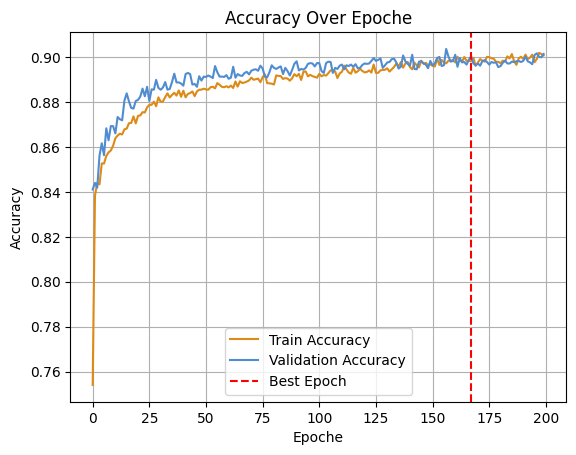

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy', color="#dd8a16ff")
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color="#4f8cd1")
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Epoch')
plt.xlabel('Epoche')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epoche')
plt.grid(True)
plt.show()

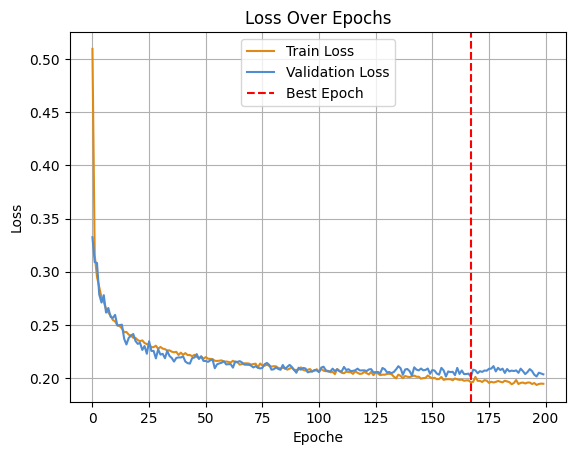

In [ ]:
# Loss
plt.plot(history.history['loss'], label='Train Loss', color="#dd8a16ff")
plt.plot(history.history['val_loss'], label='Validation Loss', color="#4f8cd1")
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Epoch')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.grid(True)
plt.show()

### Valutazione :

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9002 - loss: 0.2040
Test Accuracy: 0.9012
Test Loss: 0.2036


-------------------------------------------------------------------------------

### Predizione e Threshold per ottenere 0/1 :

In [ ]:
y_pred_probs = model.predict(X_test).flatten() # Probabilità previste
y_pred = (y_pred_probs > 0.5).astype(int)  # treeshold di 0.5 per classificazione binaria


241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Confusion Matrix :

[[5320  509]
 [ 253 1627]]


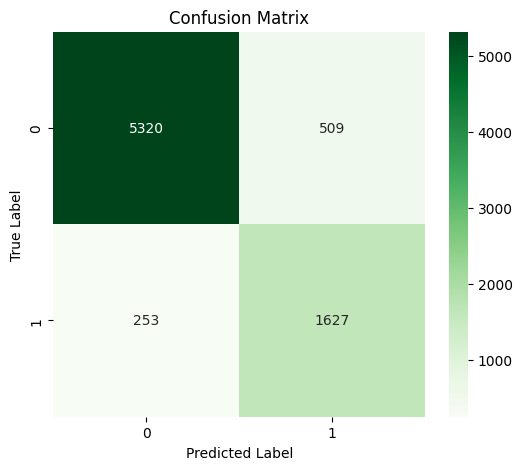

In [ ]:
print(confusion_matrix(y_test, y_pred))

# Rappresentazione della matrice di confusione
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')

plt.xlabel('Predicted Label') # valori predetti
plt.ylabel('True Label') # valori reali
plt.title('Confusion Matrix')
plt.show()



----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Classification Report (Precision, Recall, F1) :

In [ ]:
print(classification_report(y_test, y_pred, target_names=['Negato[0]', 'Approvato[1]']))

              precision    recall  f1-score   support

   Negato[0]       0.95      0.91      0.93      5829
Approvato[1]       0.76      0.87      0.81      1880

    accuracy                           0.90      7709
   macro avg       0.86      0.89      0.87      7709
weighted avg       0.91      0.90      0.90      7709



-------------------------------------------------------------------------------

### ROC Curve e AUC :

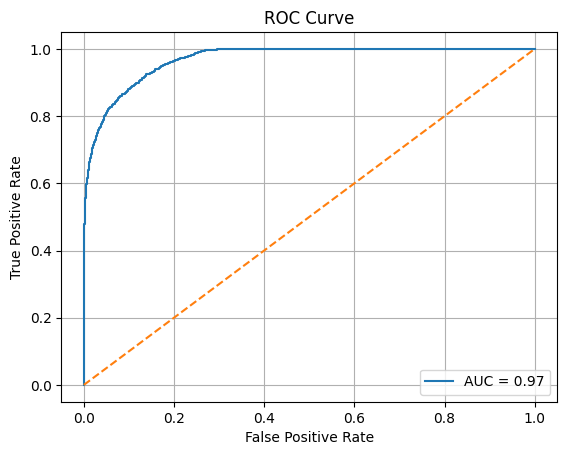

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


AUC = 0.97 indica che il modello ha una forte capacità discriminante: distingue molto bene le classi 0 e 1.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Visualizzazione della rete neurale : 

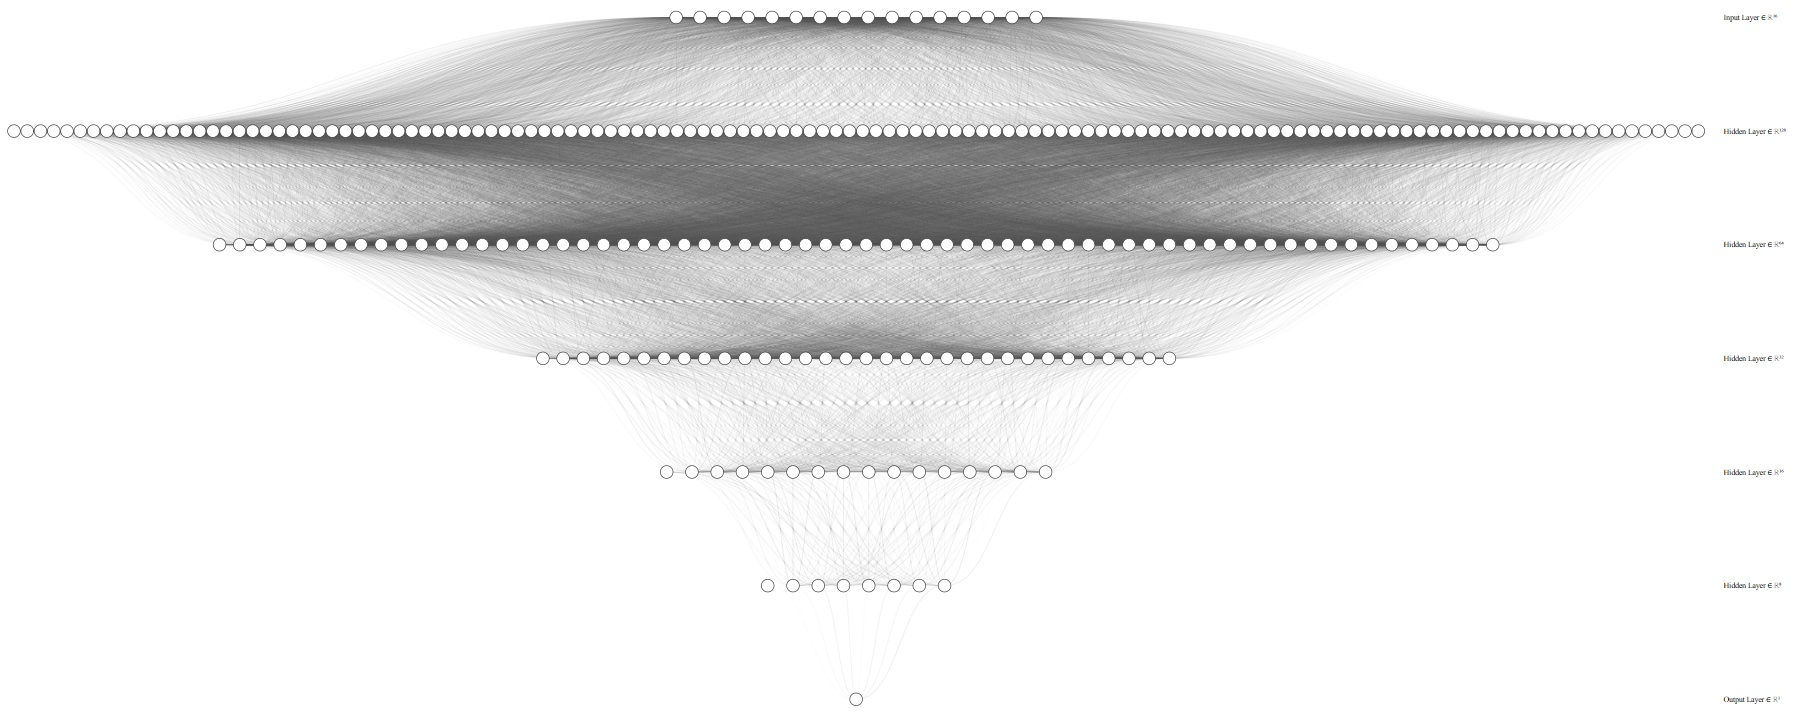

In [ ]:
from IPython.display import Image

Image(filename=r"C:\Users\torre\Pictures\Neural_Network_2.jpg")
